In [66]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.special as sc
import copy


import sys
sys.path.append('../Modules')
import Image_Fits_Stats
import Visual_analysis
import COSMOS_preprocessing_utils as utils
import matplotlib as mpl
import seaborn as sns

In [70]:
df=pd.read_csv('../Data/Radial_cut=0.05/Labels_0_50932.csv',index_col=0)
galaxies=np.load('../Data/Radial_cut=0.05/Images_0_50932.npy')

nonunifomity=np.zeros(len(galaxies))

for i,image in enumerate(galaxies):
    image=copy.deepcopy(image)
    nonunifomity[i]=image.max()/image.mean()

df['Background_size']=df['Background_x_size']*df['Background_y_size']

def change_noise(series):
    if (series.Background_x_size<20) or (series.Background_y_size<20):
        series.Noise_sigma=series.COSMOS_noise

#_=df.apply(change_noise,axis=1)

COSMOS_Sersic_columns=['COSMOS_Sersic_I','COSMOS_Sersic_HLR','COSMOS_Sersic_n','COSMOS_Sersic_q',
                'COSMOS_Sersic_x0','COSMOS_Sersic_y0','COSMOS_Sersic_phi']

df['PSNR']=20*np.log10(df['max_I']/df['Noise_sigma'])

df['NonUniformity']=10*np.log10(nonunifomity)

# Dataset overview

In [71]:
import Dataset_overview_filtering as overview
df.describe().iloc[1:][['PSNR', 'NonUniformity','R_cut','Background_size','COSMOS_Sersic_n','Scaling_factor']]

PSNR  NonUniformity      R_cut  Background_size  COSMOS_Sersic_n  \
mean  39.555870      12.811487  24.746904      9568.161578         1.898133   
std   10.339349       2.495328   7.674465     14212.234748         1.546292   
min   15.887755       7.128164   0.000000       136.000000         0.100000   
25%   31.813980      10.890688  18.000000      4876.000000         0.807135   
50%   37.787620      12.396428  27.000000      6612.000000         1.277303   
75%   45.553965      14.482370  32.000000      9512.000000         2.505364   
max   85.695770      29.675066  32.000000    432064.000000         6.000000   

      Scaling_factor  
mean        0.911476  
std         0.148447  
min         0.196319  
25%         0.864865  
50%         1.000000  
75%         1.000000  
max         1.000000

Ratio between downscaling factors with and without preprocessing

In [117]:
(df.Original_x_size/64/df.Scaling_factor).describe()

count    50799.000000
mean         2.493524
std          1.795092
min          1.250000
25%          1.625000
50%          1.906250
75%          2.656250
max         39.869141
dtype: float64

Fraction of not scaled galaxies

In [118]:
((1/df.Scaling_factor)==1).sum()/len(df)

0.6371385263489439

# Filtering

In [72]:
#Very small objects that do not show any structure, hence appear to be useless
mask_dot_like=(df.NonUniformity>=15) | (df.COSMOS_Sersic_n>=2.3) | (df.R_cut<15)

#Signal-to-noise ratio filtering
mask_SNR=df.PSNR>=30

print("Total number of galaxies in the dataset ",len(df))
print("Number of too noisy galaxies",(df.PSNR<30).sum())
print('Number of dot-like galaxies',mask_dot_like.sum())

Filtering_mask=mask_SNR & ~mask_dot_like
df_filtered=df[Filtering_mask]
Filtered_galaxies=galaxies[df_filtered.index]
df_filtered.reset_index(inplace=True,drop=True)

print("Number of filtered galaxies",len(df_filtered))

Total number of galaxies in the dataset  50799
Number of too noisy galaxies 8953
Number of dot-like galaxies 16531
Number of filtered galaxies 25475


In [73]:
df_filtered.describe().iloc[1:][['Ellipticity','R_cut', 'Scaling_factor',
       'Background_size', 'PSNR', 'NonUniformity']]

Ellipticity      R_cut  Scaling_factor  Background_size       PSNR  \
mean     0.604598  27.816801        0.886864      7611.357645  37.791665   
std      0.188554   5.094121        0.164309      5550.344576   6.193848   
min      0.120250  15.000000        0.223776       152.000000  30.001925   
25%      0.456007  24.000000        0.800000      4896.000000  33.108913   
50%      0.604528  31.000000        1.000000      6400.000000  36.367846   
75%      0.755245  32.000000        1.000000      8736.000000  40.861338   
max      1.000000  32.000000        1.000000    169480.000000  72.666477   

      NonUniformity  
mean      11.860345  
std        1.483854  
min        7.128164  
25%       10.763885  
50%       11.842173  
75%       12.957977  
max       14.999739

In [116]:
(1/df_filtered.Scaling_factor).describe()

count    25475.000000
mean         1.187322
std          0.339780
min          1.000000
25%          1.000000
50%          1.000000
75%          1.250000
max          4.468750
Name: Scaling_factor, dtype: float64

100 random galaxies from the filtered dataset

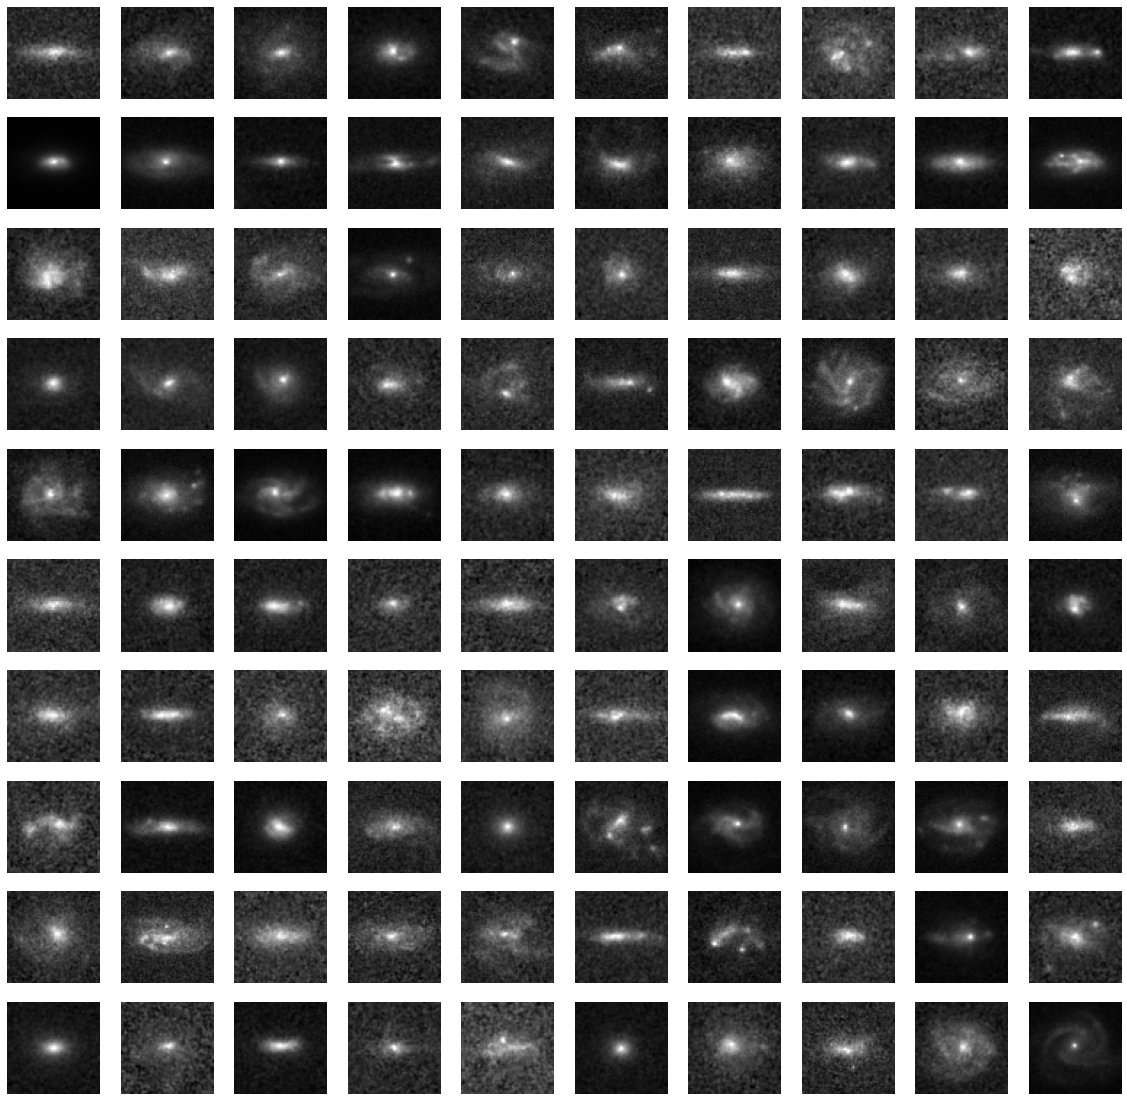

In [74]:
overview.Show_100(Filtered_galaxies,df_filtered.sample(frac=1),cmap='gray')

# Impact of proper scaling

In [6]:
df_for_scaling=df.copy()
df_for_scaling['Scaling_difference']=64/df['Original_x_size']/df['Scaling_factor']

In [7]:
Highest_proper_scaling_impact=df_for_scaling[(~mask_dot_like) & (df.R_cut>31) & (df.PSNR>35)].sort_values('Scaling_difference',ascending=True).iloc[0]

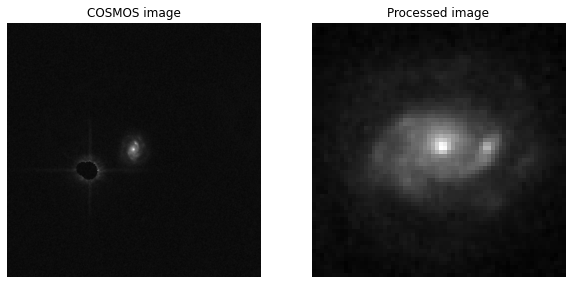

In [124]:
fig,ax=plt.subplots(1,2,figsize=(10,7))

index=int(Highest_proper_scaling_impact.COSMOS_index)

gal=utils.get_COSMOS_galaxy(index)
original_image=gal.drawImage(use_true_center=True, method='auto').array
ax[0].imshow(original_image,cmap='gray')
ax[0].axis('off')
ax[0].set_title('COSMOS image')

_,image,parameters=utils.create_Galaxy(index)

ax[1].imshow(image,cmap='gray')
ax[1].axis('off')
ax[1].set_title('Processed image')
#plt.savefig('Before_processing_after.png')
plt.show()

In [121]:
Highest_proper_scaling_impact.Original_x_size/64

8.75

In [122]:
1/Highest_proper_scaling_impact.Scaling_factor

1.25

# Cutting methods

In [22]:
def get_galaxy_and_cut(index,Radial_profile_threshold=0.05):
    
    parameters=utils.create_Parametric_description(index)
    
    #Get GSObject and noise
    gal=utils.get_COSMOS_galaxy(index)
    original_image=gal.drawImage(use_true_center=True, method='auto').array

    #Extracting the parameters to build elliptical coordinates
    Sersic_fit,_=Image_Fits_Stats.fit_image(original_image,noise_std=parameters['COSMOS_noise'],exposure_time=2028)
    Ellipticity,x0,y0,Angle=Sersic_fit[-4:]
    Radial_profile=Image_Fits_Stats.Radial_profile(original_image,Ellipticity,x0,y0,Angle)

    #Getting border of galaxy from radial profile
    Radial_profile[-1]=np.nan_to_num(Radial_profile[-1])
    Radial_profile=Radial_profile-Radial_profile[-1]
    Radial_profile/=np.nanmax(Radial_profile)
    R_cut=np.where((Radial_profile<Radial_profile_threshold))[0][0]
        
    return original_image,Sersic_fit,Radial_profile,R_cut

def get_different_R_cut(Radial_profile,Radial_profile_threshold=0.05):
    Radial_R_cut=np.where((Radial_profile<Radial_profile_threshold))[0][0]
    
    increase_curve=copy.deepcopy(Radial_profile)
    increase_curve=np.nan_to_num(increase_curve)
    for i in range(1,len(Radial_profile)):
        increase_curve[i]+=increase_curve[i-1]
    increase_curve/=increase_curve[-1]
    Luminosity_R_cut=np.where((increase_curve>0.95))[0][0]
    
    return Radial_R_cut,Luminosity_R_cut,increase_curve

def plot_cuts(image,Radial_profile,Sersic_fit,border_size=1,color_scheme='black',noise_sigma=0.005):
    img_col=np.ones((image.shape[0],image.shape[1],3))
    image_to_transform=copy.deepcopy(image)
    image_to_transform=image_to_transform/image_to_transform.max()
    if color_scheme=='white':
        image_to_transform[image_to_transform<2*noise_sigma]=2*noise_sigma
        for i in range(3):
            log_image=-np.log10(image_to_transform)
            log_image-=log_image.min()
            img_col[:,:,i]=log_image/log_image.max()
    
    elif color_scheme=='black':
        image_to_transform[image_to_transform<2*noise_sigma]=2*noise_sigma
        for i in range(3):
            #log_image=np.log10(image_to_transform)
            #log_image-=log_image.min()
            #img_col[:,:,i]=log_image/log_image.max()
            img_col[:,:,i]=image_to_transform
            
            
    x = np.linspace(0, image.shape[1]-1, image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    X, Y = np.meshgrid(x, y)
    I,HLR,n,Ellipticity,x0,y0,Angle=Sersic_fit
    R=np.sqrt(np.power((X-x0)*np.cos(Angle)+(Y-y0)*np.sin(Angle),2)+
        np.power((Y-y0)*np.cos(Angle)-(X-x0)*np.sin(Angle),2)/np.power(Ellipticity,2))
    mask_radial=np.where((R<(Radial_R_cut+border_size)) & (R>(Radial_R_cut-border_size)))
    mask_luminosity=np.where((R<(Luminosity_R_cut+border_size)) & (R>(Luminosity_R_cut-border_size)))
    
    for i in range(len(mask_radial[0])):
        if color_scheme=='white':
            img_col[mask_radial[0][i],mask_radial[1][i]]=mpl.colors.to_rgb('C0')
        elif color_scheme=='black':
            img_col[mask_radial[0][i],mask_radial[1][i]]=mpl.colors.to_rgb('red')
    for i in range(len(mask_luminosity[0])):
        if color_scheme=='white':
            img_col[mask_luminosity[0][i],mask_luminosity[1][i]]=mpl.colors.to_rgb('C1')
        elif color_scheme=='black':
            img_col[mask_luminosity[0][i],mask_luminosity[1][i]]=mpl.colors.to_rgb('C1')
        
    return img_col

## Explanation

In [13]:
index_to_study=[10614,17269,25882,28193]

In [14]:
indices_to_compare=[33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]

In [23]:
index=index_to_study[2]
_,Sersic_fit,Radial_profile,_=get_galaxy_and_cut(index)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

gal=utils.get_COSMOS_galaxy(index)
gal=utils.rotate_galaxy(gal,Sersic_fit[-1])
image=gal.drawImage(use_true_center=True, method='auto').array

_,_,_,_,COSMOS_noise_variance=utils.cat.getRealParams(index)
Sersic_fit,_=Image_Fits_Stats.fit_image(image,noise_std=np.sqrt(COSMOS_noise_variance),exposure_time=2028)

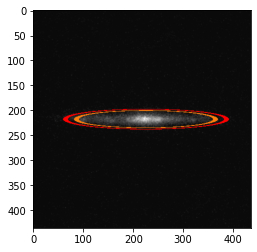

In [24]:
image_with_cuts=plot_cuts(image,Radial_profile,Sersic_fit,5,color_scheme='black',noise_sigma=df.iloc[index].Noise_sigma/image.max())
plt.imshow(image_with_cuts)

<ipython-input-28-54969f97683a>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([0,1])
<ipython-input-28-54969f97683a>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([0,1])
<ipython-input-28-54969f97683a>:59: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout(h_pad=-0.6)


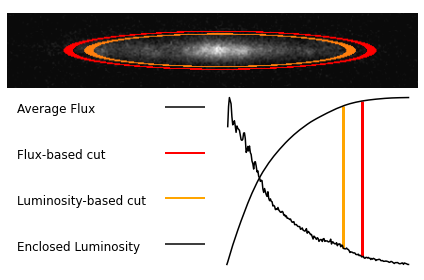

In [28]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(4, 2,width_ratios=[1,1],
                          height_ratios=[1,1,2,2])

ax0=fig.add_subplot(gs[:, :])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.axis('off')

image_to_show=copy.deepcopy(image_with_cuts)
#image_to_show[:,0]=np.zeros((len(image_to_show),3))
#image_to_show[:,-1]=np.zeros((len(image_to_show),3))
ax1 = fig.add_subplot(gs[0:2, :])
ax1.imshow(image_to_show[(218-40):(218+40),:],norm=mpl.colors.LogNorm(vmin=0.01, vmax=1))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')
ax2 = fig.add_subplot(gs[2:, 1])


#Radial profile and Increase curve
ax2.plot(Radial_profile,label='Radial profile',color='black')
ax2.plot(increase_curve,label='Increase curve',color='black')
#Flux cut
ax2.vlines(Radial_R_cut,0.05,0.98,color='red',linewidth=3)
#Luminoisty cut
ax2.vlines(Luminosity_R_cut,0.1,0.95,color='orange',linewidth=3)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')

#Labels
ax3 = fig.add_subplot(gs[2:, 0])

ax3.text(0.05, 0.875, 'Average Flux', color='black',size=12)
ax3.hlines(0.905,0.8,1,color='black')

ax3.text(0.05, 0.625, 'Flux-based cut', color='black',size=12)
ax3.hlines(0.655,0.8,1,color='red',linewidth=2)


ax3.text(0.05, 0.375, 'Luminosity-based cut', color='black',size=12)
ax3.hlines(0.405,0.8,1,color='orange',linewidth=2)

ax3.text(0.05, 0.125, 'Enclosed Luminosity', color='black',size=12)
ax3.hlines(0.155,0.8,1,color='black')



ax3.set_xticklabels([0,1])
ax3.set_xticks([0,1])
ax3.set_yticklabels([0,1])
ax3.set_yticks([0,1])
ax3.axis('off')



#plt.savefig('Cut_explanation.png')
plt.tight_layout(h_pad=-0.6)
plt.show()

## Comparison of Cuts for different galaxies

In [29]:
index=indices_to_compare[7]
image,Sersic_fit,Radial_profile,R_cut=get_galaxy_and_cut(index)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

([], [])

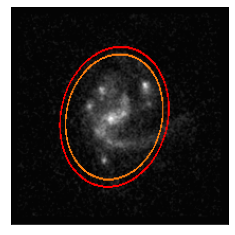

In [30]:
img_irreg=plot_cuts(image,Radial_profile,Sersic_fit,1,color_scheme='black',noise_sigma=df.iloc[index].Noise_sigma/image.max())
plt.imshow(img_irreg)
plt.xticks([])
plt.yticks([])

In [31]:
index=1
image,Sersic_fit,Radial_profile,R_cut=get_galaxy_and_cut(index)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

([], [])

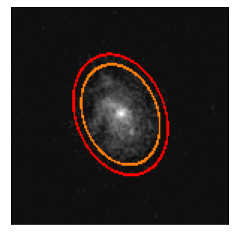

In [32]:
img_diskface=plot_cuts(image,Radial_profile,Sersic_fit,1,color_scheme='black',noise_sigma=df.iloc[index].Noise_sigma/image.max())
plt.imshow(img_diskface)
plt.xticks([])
plt.yticks([])

In [33]:
index=index_to_study[0]
image,Sersic_fit,Radial_profile,R_cut=get_galaxy_and_cut(index)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

([], [])

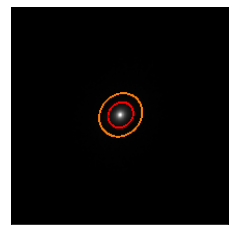

In [34]:
img_dotlike=plot_cuts(image,Radial_profile,Sersic_fit,1,color_scheme='black',noise_sigma=df.iloc[index].Noise_sigma/image.max())
plt.imshow(img_dotlike)
plt.xticks([])
plt.yticks([])

In [35]:
index=index_to_study[2]
image,Sersic_fit,Radial_profile,R_cut=get_galaxy_and_cut(index)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

([], [])

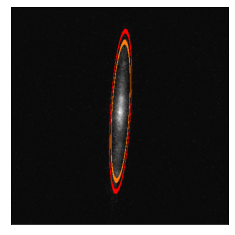

In [36]:
img_diskedge=plot_cuts(image,Radial_profile,Sersic_fit,5,color_scheme='black',noise_sigma=df.iloc[index].Noise_sigma/image.max())
plt.imshow(img_diskedge)
plt.xticks([])
plt.yticks([])

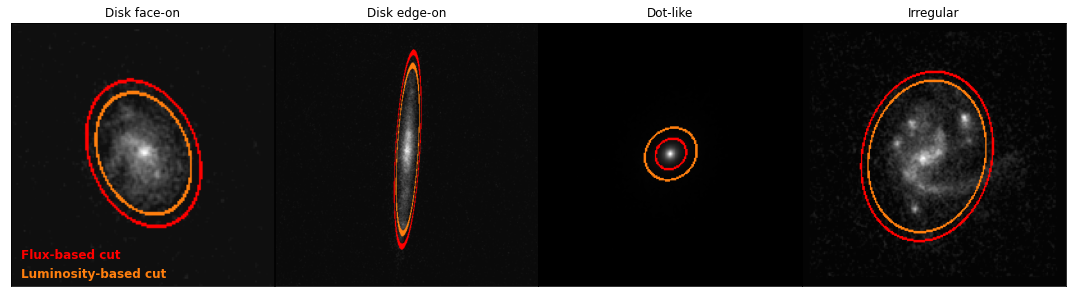

In [38]:
f, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].imshow(img_diskface)
ax[0].set_title("Disk face-on")
ax[0].text(5, 130, 'Flux-based cut', color='red',weight='bold',size=12)
ax[0].text(5, 141, 'Luminosity-based cut', color='C1',weight='bold',size=12)
ax[1].imshow(img_diskedge)
ax[1].set_title("Disk edge-on")
ax[2].imshow(img_dotlike)
ax[2].set_title("Dot-like")
ax[3].imshow(img_irreg)
ax[3].set_title("Irregular")
for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])


plt.tight_layout(w_pad=-0.3)
#plt.savefig('Cut_comparison.png')
plt.show()

### Comparison of R_cut thresholds

In [39]:
Success,image_1,parameters=utils.create_Galaxy(indices_to_compare[7],0.01)
Success,image_5,parameters=utils.create_Galaxy(indices_to_compare[7],0.05)

In [40]:
image_1/=image_1.max()
image_5/=image_5.max()
Small_galaxy_old_reconstruction=np.load('./Different_cut_comparison/Old_data_Old_model.npy')
Small_galaxy_new_reconstruction=np.load('./Different_cut_comparison/Old_data_New_model.npy')
Big_galaxy_old_reconstruction=np.load('./Different_cut_comparison/New_data_Old_model.npy')
Big_galaxy_new_reconstruction=np.load('./Different_cut_comparison/New_data_New_model.npy')

In [41]:
gaussian_noise=df.iloc[indices_to_compare[7]].Noise_sigma/image_5.max()


#Chi_sq=(sigma^2)*MSE/(image/2028+gauss_norm^2)
#sigma=1/30 - it is highest noise in the dataset 
def chisq(image_true,image_pred,noise=gaussian_noise):
    image_true[image_true<0]=0
    Poisson_var=image_true/2028
    Gaussian_var=noise**2
    noise_var=Poisson_var+Gaussian_var
    SE=(image_true-image_pred)**2
    return np.mean(SE/noise_var*(1/30)**2)

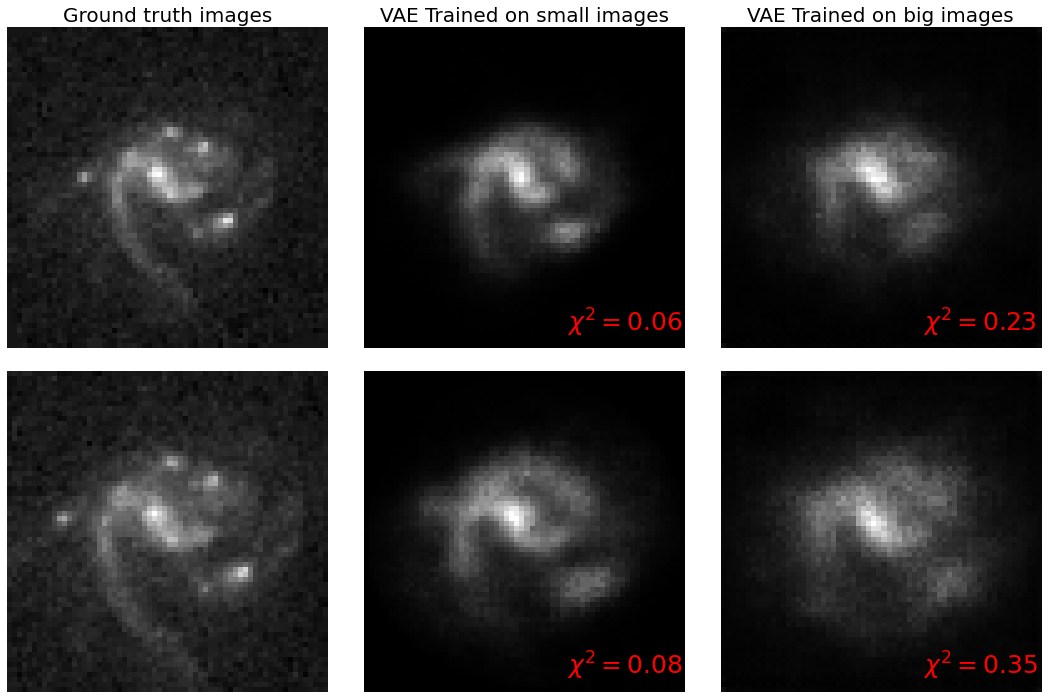

In [42]:
f, ax = plt.subplots(2, 3, figsize=(15,10))

#Original images

ax[0,0].imshow(image_1,cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth images',fontsize=20)

ax[1,0].imshow(image_5,cmap='gray')
ax[1,0].axis('off')


ax[0,1].imshow(Small_galaxy_old_reconstruction,cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('VAE Trained on small images',fontsize=20)
ax[0,1].text(40, 60,r'$\chi^{2}=$'+'{:.2f}'.format(chisq(image_1,Small_galaxy_old_reconstruction)), color='red',size=25)

ax[0,2].imshow(Small_galaxy_new_reconstruction,cmap='gray')
ax[0,2].axis('off')
ax[0,2].set_title('VAE Trained on big images',fontsize=20)
ax[0,2].text(40, 60, r'$\chi^{2}=$'+'{:.2f}'.format(chisq(image_1,Small_galaxy_new_reconstruction)), color='red',size=25)



ax[1,1].imshow(Big_galaxy_old_reconstruction,cmap='gray')
ax[1,1].axis('off')
ax[1,1].text(40, 60, r'$\chi^{2}=$'+'{:.2f}'.format(chisq(image_5,Big_galaxy_old_reconstruction)), color='red',size=25)



ax[1,2].imshow(Big_galaxy_new_reconstruction,cmap='gray')
ax[1,2].axis('off')
ax[1,2].text(40, 60, r'$\chi^{2}=$'+'{:.2f}'.format(chisq(image_5,Big_galaxy_new_reconstruction)), color='red',size=25)



plt.tight_layout()
#plt.savefig('Networks_comparison.png')
plt.show()

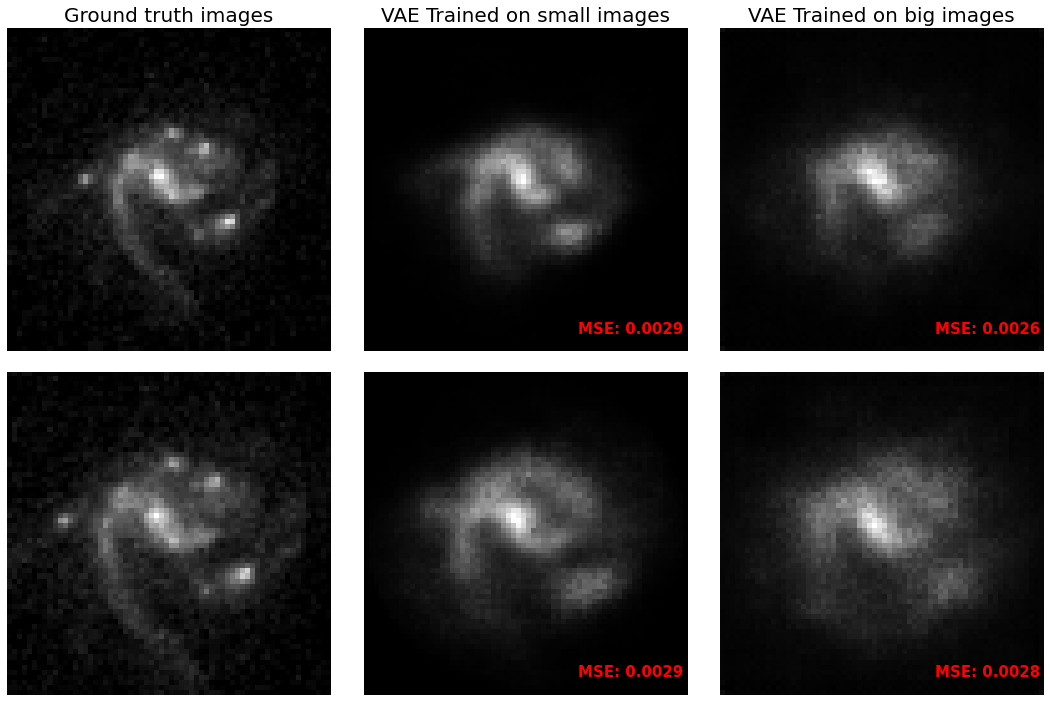

In [43]:
f, ax = plt.subplots(2, 3, figsize=(15,10))

#Original images

ax[0,0].imshow(image_1,cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('Ground truth images',fontsize=20)

ax[1,0].imshow(image_5,cmap='gray')
ax[1,0].axis('off')


ax[0,1].imshow(Small_galaxy_old_reconstruction,cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('VAE Trained on small images',fontsize=20)
ax[0,1].text(42, 60, 'MSE: {:.4f}'.format(np.mean((Small_galaxy_old_reconstruction-image_1)**2)), color='red',weight='bold',size=15)

ax[0,2].imshow(Small_galaxy_new_reconstruction,cmap='gray')
ax[0,2].axis('off')
ax[0,2].set_title('VAE Trained on big images',fontsize=20)
ax[0,2].text(42, 60, 'MSE: {:.4f}'.format(np.mean((Small_galaxy_new_reconstruction-image_1)**2)), color='red',weight='bold',size=15)



ax[1,1].imshow(Big_galaxy_old_reconstruction,cmap='gray')
ax[1,1].axis('off')
ax[1,1].text(42, 60, 'MSE: {:.4f}'.format(np.mean((Big_galaxy_old_reconstruction-image_5)**2)), color='red',weight='bold',size=15)



ax[1,2].imshow(Big_galaxy_new_reconstruction,cmap='gray')
ax[1,2].axis('off')
ax[1,2].text(42, 60, 'MSE: {:.4f}'.format(np.mean((Big_galaxy_new_reconstruction-image_5)**2)), color='red',weight='bold',size=15)



plt.tight_layout()
#plt.savefig('Networks_comparison.png')
plt.show()

## Noise extraction image

In [44]:
index=0
_,Sersic_fit,Radial_profile,_=get_galaxy_and_cut(index)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

gal=utils.get_COSMOS_galaxy(index)
gal=utils.rotate_galaxy(gal,Sersic_fit[-1])
image=gal.drawImage(use_true_center=True, method='auto').array

In [45]:
_,_,_,_,COSMOS_noise_variance=utils.cat.getRealParams(index)
Sersic_fit,_=Image_Fits_Stats.fit_image(image,noise_std=np.sqrt(COSMOS_noise_variance),exposure_time=2028)

In [46]:
Ellipticity,x0,y0,Angle=Sersic_fit[-4:]

In [47]:
image.shape

(244, 244)

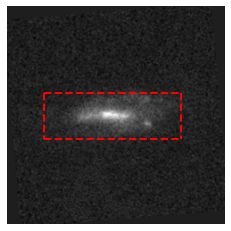

In [50]:
plt.imshow(image,cmap='gray')
plt.axis('off')
#Horizontal
plt.hlines(y0+Ellipticity*Radial_R_cut,x0-Radial_R_cut,x0+Radial_R_cut,color='red',linestyles='dashed',linewidth=2)
plt.hlines(y0-Ellipticity*Radial_R_cut,x0-Radial_R_cut,x0+Radial_R_cut,color='red',linestyles='dashed',linewidth=2)
#Vertical
plt.vlines(x0-Radial_R_cut,y0-Ellipticity*Radial_R_cut,y0+Ellipticity*Radial_R_cut,color='red',linestyles='dashed',linewidth=2)
plt.vlines(x0+Radial_R_cut,y0-Ellipticity*Radial_R_cut,y0+Ellipticity*Radial_R_cut,color='red',linestyles='dashed',linewidth=2)
#plt.savefig('Image_for_bkg.png')

In [290]:
import scipy.stats as stats
1/stats.norm.ppf(0.75)

1.482602218505602

In [295]:
df['Background_size'].min()

136.0

In [296]:
df['Background_size'].median()

6612.0

In [62]:
unprocessed_df=pd.read_csv('../Data/Radial_cut=0.05/Labels_0_50932.csv',index_col=0)

In [65]:
unprocessed_df['Minimal_Bkg_size']=np.minimum(unprocessed_df.Background_x_size,unprocessed_df.Background_y_size)
unprocessed_df['Noise_ratio']=unprocessed_df['COSMOS_noise']/unprocessed_df['Noise_sigma']

In [68]:
unprocessed_df['Minimal_Bkg_size'].describe()

count    50799.000000
mean        69.953897
std         40.763187
min          2.000000
25%         48.000000
50%         64.000000
75%         80.000000
max        628.000000
Name: Minimal_Bkg_size, dtype: float64

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


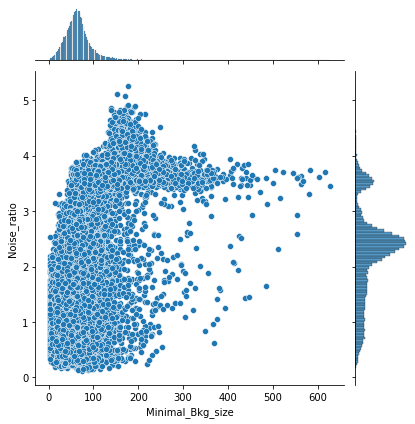

In [67]:
sns.jointplot(unprocessed_df['Minimal_Bkg_size'],unprocessed_df['Noise_ratio'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


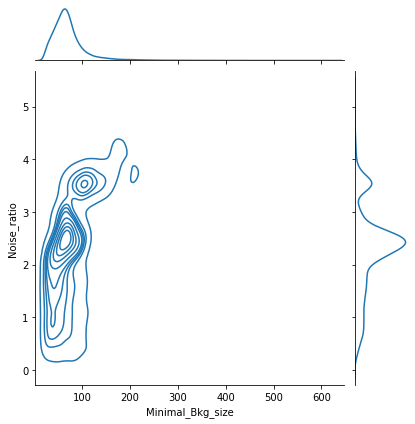

In [102]:
mask_reliable_noise=(unprocessed_df['Minimal_Bkg_size']>20)
sns.jointplot(unprocessed_df[mask_reliable_noise]['Minimal_Bkg_size'],unprocessed_df[mask_reliable_noise]['Noise_ratio'],kind='kde')

In [99]:
unprocessed_df['Normalised_COSMOS_noise']=unprocessed_df['COSMOS_noise']/unprocessed_df['max_I']
unprocessed_df['Normalised_MAD_noise']=unprocessed_df['Noise_sigma']/unprocessed_df['max_I']

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


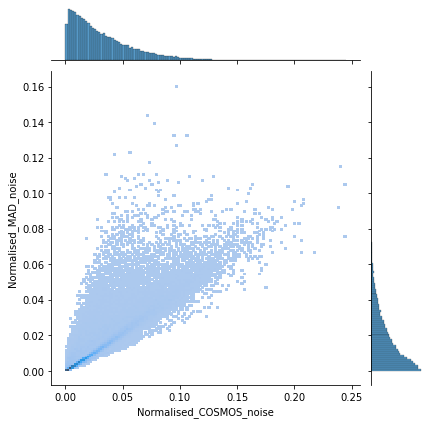

In [108]:
sns.jointplot(unprocessed_df['Normalised_COSMOS_noise'],unprocessed_df['Normalised_MAD_noise'],kind='hist')

# Typical galaxies

NonUniformity 12.218406235948793
Number of galaxies 2761


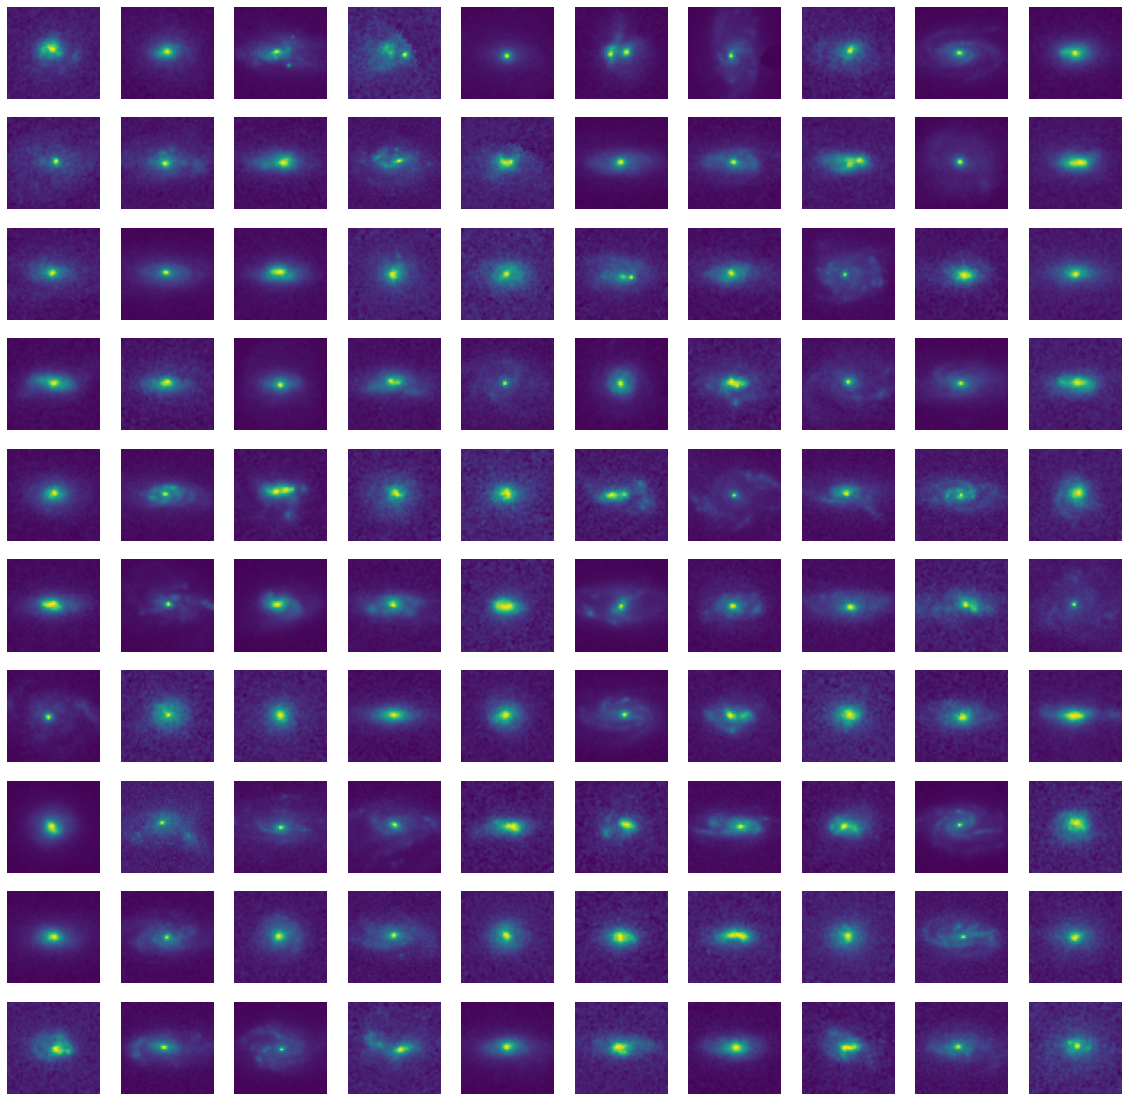

In [89]:
df_filt=overview.Show_filtered(Filtered_galaxies,df_filtered[(df_filtered.Ellipticity>0.4) & (df_filtered.PSNR>40)],'NonUniformity',ascending=True,threshold=12,Index_from=300,invert_colors=False,cut_negatives=False)

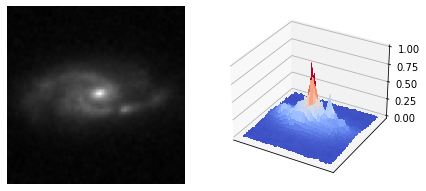

In [86]:
image=Filtered_galaxies[int(df_filt.iloc[172].name)]
image=image/image.max()
x = np.linspace(0, 64, 64)
y = np.linspace(0, 64, 64)
X, Y = np.meshgrid(x, y)

fig=plt.figure(figsize=(7,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(image,cmap='gray')
ax.axis('off')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(X, Y, image, cmap=mpl.cm.coolwarm,
    linewidth=0, antialiased=False)
#ax.set_zlim(0,image.max())
#ax.set_zticks([])
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Typical_galaxy_for_Sersic_Chameleon.png')
plt.show()

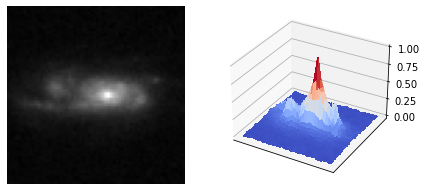

In [98]:
image=Filtered_galaxies[int(df_filt.iloc[76].name)]
image=image/image.max()
x = np.linspace(0, 64, 64)
y = np.linspace(0, 64, 64)
X, Y = np.meshgrid(x, y)

fig=plt.figure(figsize=(7,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(image,cmap='gray')
ax.axis('off')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(X, Y, image, cmap=mpl.cm.coolwarm,
    linewidth=0, antialiased=False)
#ax.set_zlim(0,image.max())
#ax.set_zticks([])
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Typical_galaxy_for_Activation.png')
plt.show()

# Noise thresholding cut

In [51]:
x = np.linspace(0, 64-1, 64)
y = np.linspace(0, 64-1, 64)
X, Y = np.meshgrid(x, y)
x0=63/2
y0=63/2

In [52]:
threshold=1/20
Thresholded_galaxies=copy.deepcopy(Filtered_galaxies)
Ell_outlined_galaxies=copy.deepcopy(Filtered_galaxies)
for i in tqdm(range(len(Filtered_galaxies))):
    Thresholded_galaxies[i][Thresholded_galaxies[i]<threshold*Thresholded_galaxies[i].max()]=np.nan
    
    Ellipticity=df_filtered.iloc[i].Ellipticity
    R_cut=df_filtered.iloc[i].R_cut
    R=np.sqrt(np.power((X-x0),2)+
        np.power((Y-y0),2)/np.power(Ellipticity,2))
    Ell_outlined_galaxies[i][R>R_cut]=np.nan

100%|██████████| 25461/25461 [00:07<00:00, 3511.76it/s]


PSNR 30.001925432267463
Number of galaxies 25461


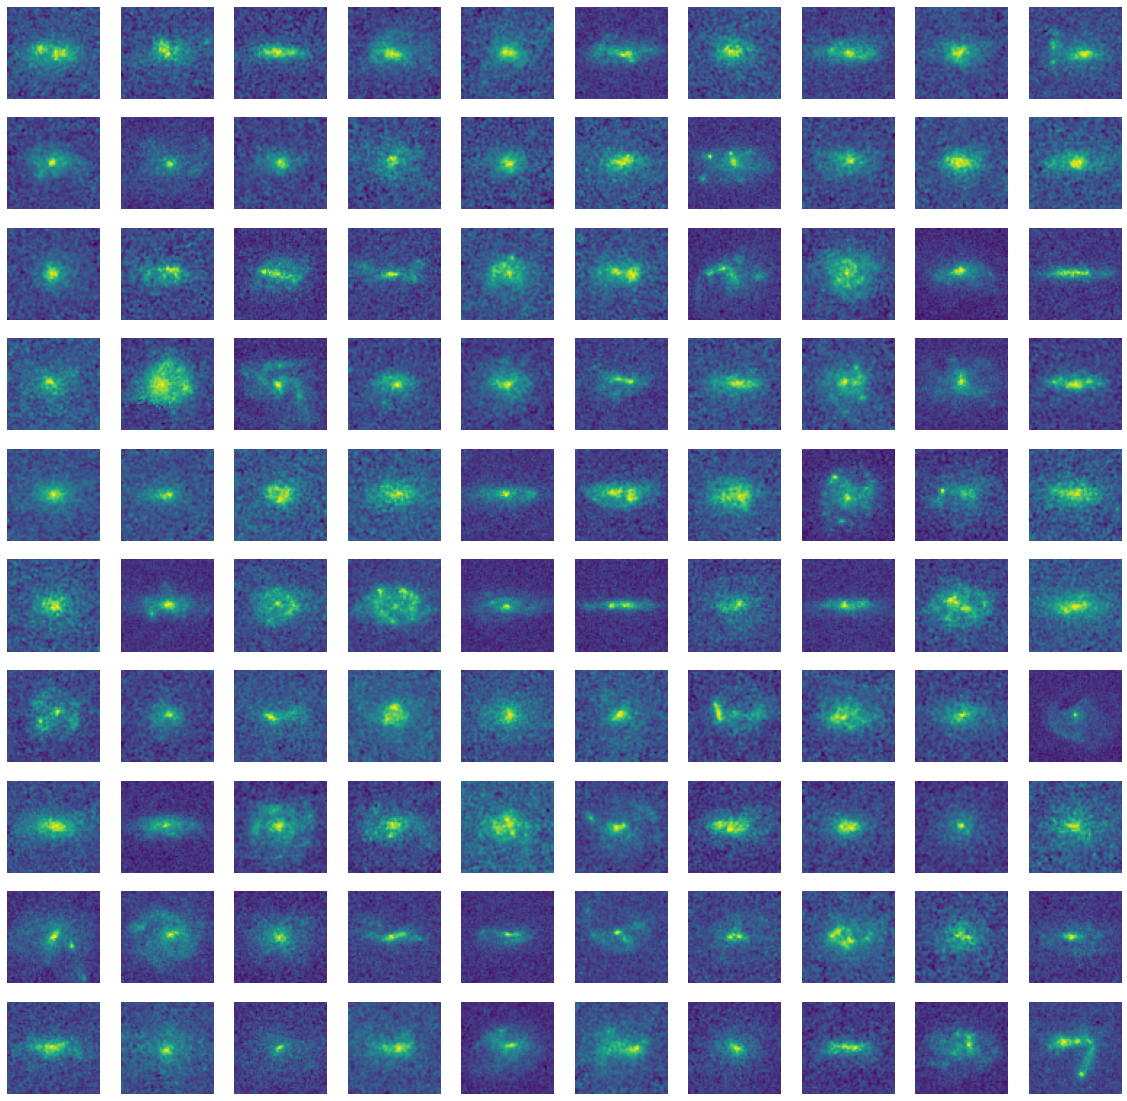

In [55]:
df_filt=overview.Show_filtered(Filtered_galaxies,df_filtered,'PSNR',ascending=True,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False)

PSNR 30.001925432267463
Number of galaxies 25461


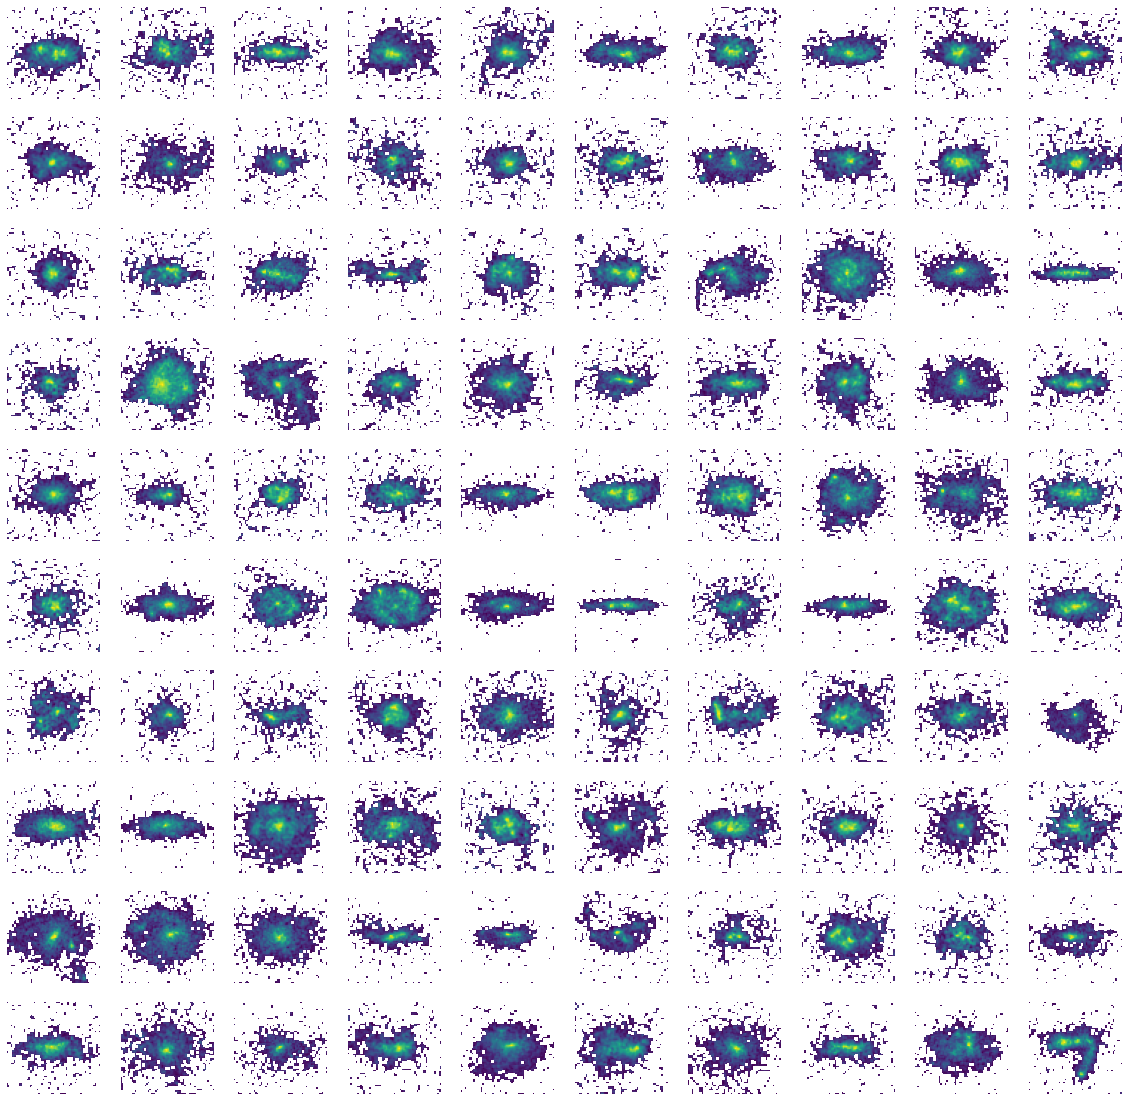

In [56]:
df_filt=overview.Show_filtered(Thresholded_galaxies,df_filtered,'PSNR',ascending=True,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False)

PSNR 30.001925432267463
Number of galaxies 25461


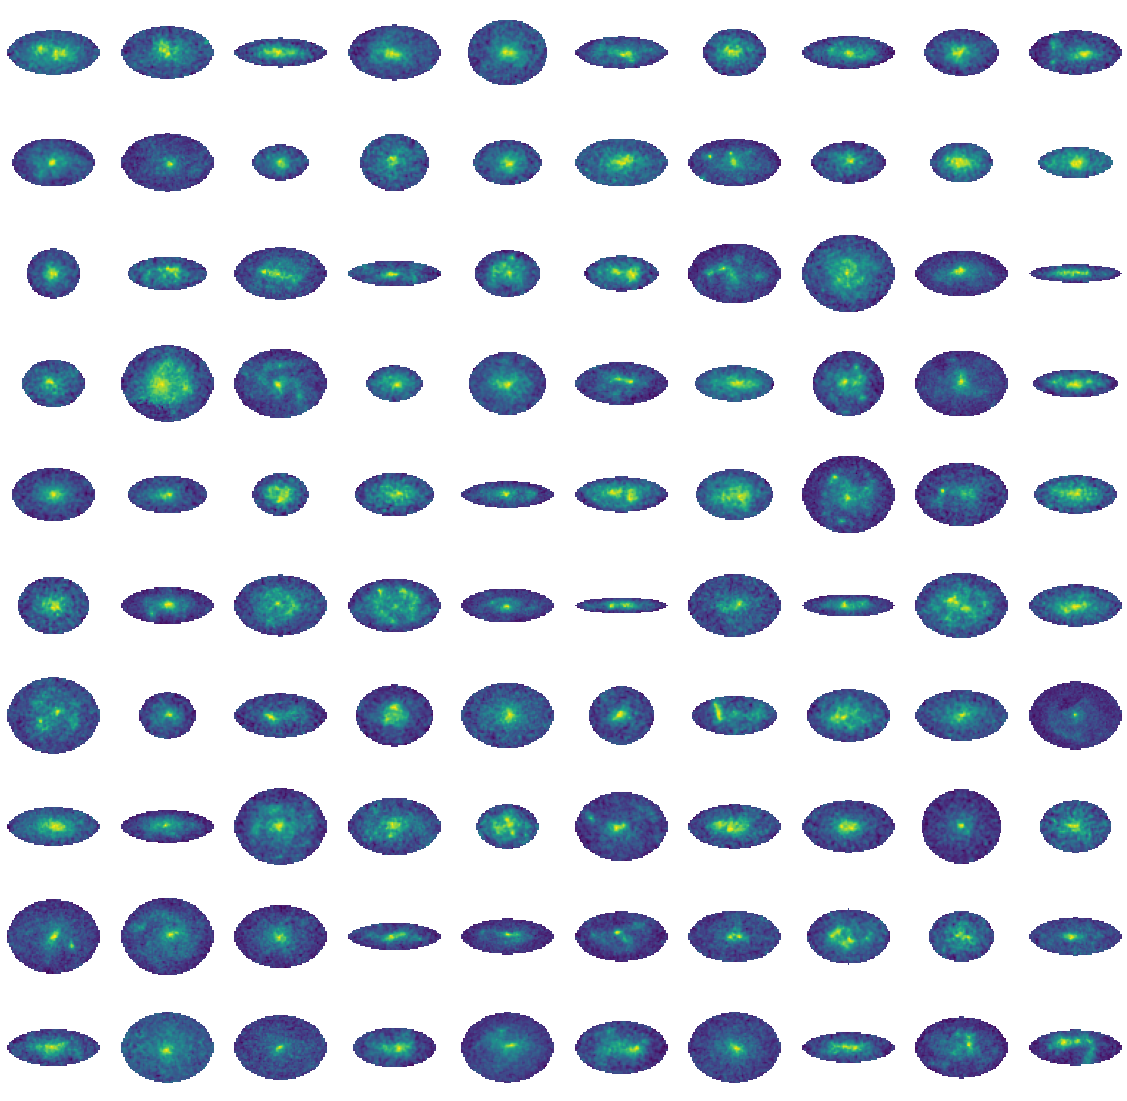

In [58]:
df_filt=overview.Show_filtered(Ell_outlined_galaxies,df_filtered,'PSNR',ascending=True,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False)

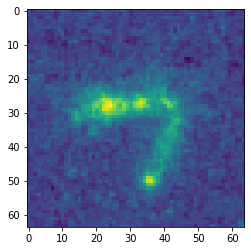

In [60]:
index=df_filt.iloc[99].name
plt.imshow(Filtered_galaxies[index])

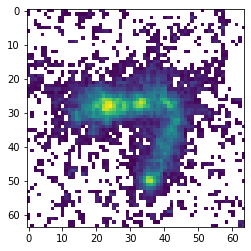

In [61]:
plt.imshow(Thresholded_galaxies[index])